# Assignment 4: Build a Supervised Autoencoder.

### Name: AIshwarya Bhethanabotla

### Due Date: Friday 5/2/2025 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?



**You are required to build and train a supervised autoencoder looks like the following.** You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


## 0. You will do the following:

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transforms such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [3]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottleneck layer with 2 as output size.
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose a different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [4]:
from keras import backend as K
from keras.layers import Input, Dense
from keras import models
from tensorflow.keras import optimizers



input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(256, activation='relu', name='encode1')(input_img)
encode2 = Dense(128, activation='relu', name='encode2')(encode1)
encode3 = Dense(64, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='linear', name='bottleneck')(encode3)


decode1 = Dense(64, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(128, activation='relu', name='decode2')(decode1)
decode3 = Dense(256, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)


ae = models.Model(input_img, decode4)
ae.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode1 (Dense)                 │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decode4 (Dense)                 │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 485,266 (1.85 MB)

 Trainable params: 485,266 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [6]:
from tensorflow.keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr,
                 batch_size=128,
                 epochs=100,
                 validation_data=(x_val, x_val))

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.2033 - val_loss: 0.0740
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0703 - val_loss: 0.0708
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0678 - val_loss: 0.0693
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0668 - val_loss: 0.0680
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0656 - val_loss: 0.0663
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0646 - val_loss: 0.0656
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0636 - val_loss: 0.0638
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0613 - val_loss: 0.0615
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0597 - val_loss: 0.0607
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - val_loss: 0.0619
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0591 - val_loss: 0.0604
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

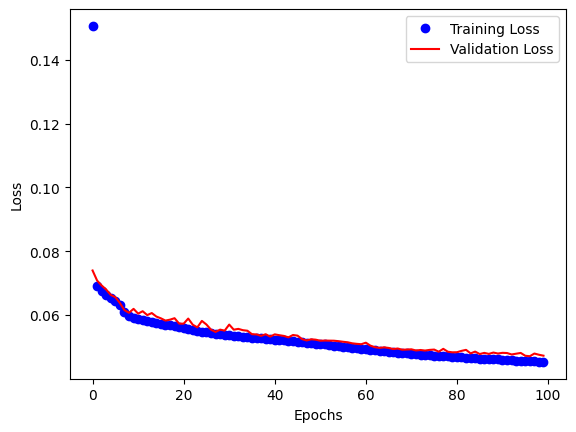

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


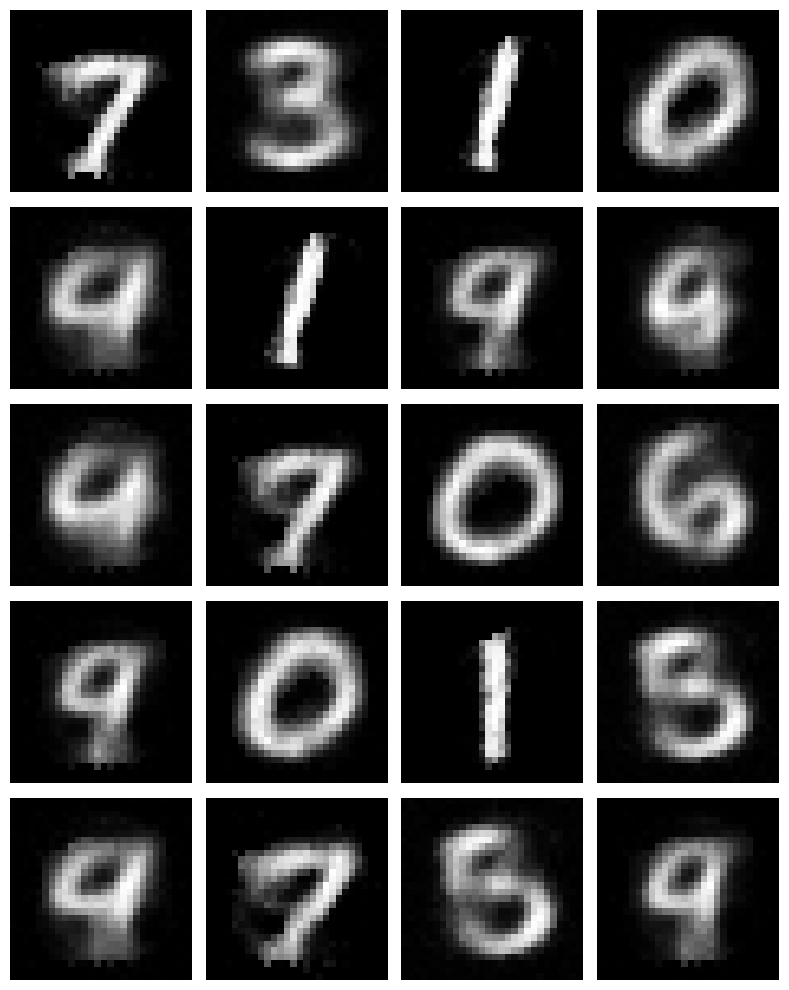

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0466
loss = 0.04701375588774681


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,242 (946.26 KB)

 Trainable params: 242,242 (946.26 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of encoded_test: (10000, 2)


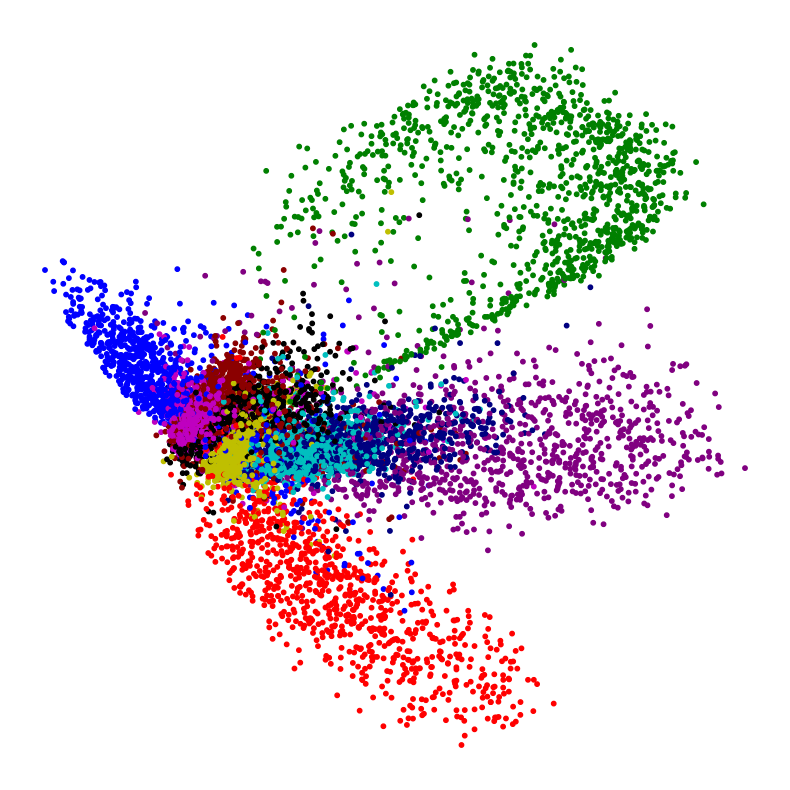

In [13]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantitatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,186 (71.04 KB)

 Trainable params: 18,186 (71.04 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr,
                        batch_size=32,
                        epochs=30,
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - acc: 0.2712 - loss: 1.9279 - val_acc: 0.4075 - val_loss: 1.4354
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.4195 - loss: 1.4066 - val_acc: 0.4873 - val_loss: 1.3456
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5040 - loss: 1.3227 - val_acc: 0.5369 - val_loss: 1.2962
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5618 - loss: 1.2827 - val_acc: 0.5765 - val_loss: 1.2534
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.5868 - loss: 1.2492 - val_acc: 0.5969 - val_loss: 1.2112
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6217 - loss: 1.1919 - val_acc: 0.6139 - val_loss: 1.1711
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6457 - loss: 1.1420 - val_acc: 0.6378 - val_loss: 1.1391
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6455 - loss: 1.1249 - val_acc: 0.6390 - val_loss: 1.1135
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

In [17]:
#Grab the val‐accuracy list
val_acc_list = history.history.get('val_acc', history.history.get('val_accuracy'))


for epoch, acc in enumerate(val_acc_list, 1):
    print(f"Epoch {epoch:2d}: val_acc = {acc*100:.2f}%")




val_loss, val_acc = classifier.evaluate(f_val, y_val, batch_size=32, verbose=0)
print(f"val_acc = {val_acc*100:.2f}%")


Epoch  1: val_acc = 40.75%
Epoch  2: val_acc = 48.73%
Epoch  3: val_acc = 53.69%
Epoch  4: val_acc = 57.65%
Epoch  5: val_acc = 59.69%
Epoch  6: val_acc = 61.39%
Epoch  7: val_acc = 63.78%
Epoch  8: val_acc = 63.90%
Epoch  9: val_acc = 63.69%
Epoch 10: val_acc = 64.64%
Epoch 11: val_acc = 64.17%
Epoch 12: val_acc = 64.93%
Epoch 13: val_acc = 64.14%
Epoch 14: val_acc = 64.93%
Epoch 15: val_acc = 65.49%
Epoch 16: val_acc = 64.70%
Epoch 17: val_acc = 65.07%
Epoch 18: val_acc = 65.52%
Epoch 19: val_acc = 65.65%
Epoch 20: val_acc = 65.44%
Epoch 21: val_acc = 65.44%
Epoch 22: val_acc = 65.97%
Epoch 23: val_acc = 66.22%
Epoch 24: val_acc = 66.12%
Epoch 25: val_acc = 66.14%
Epoch 26: val_acc = 66.07%
Epoch 27: val_acc = 65.71%
Epoch 28: val_acc = 65.86%
Epoch 29: val_acc = 65.73%
Epoch 30: val_acc = 65.98%
val_acc = 65.98%


### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.

<img src="ae.PNG"/>


### 4.1. Build the network (30 points)

In [18]:
from keras import backend as K
from keras.layers import Input, Dense
from keras import models
from tensorflow.keras import optimizers

# Clear session
K.clear_session()


input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(256, activation='relu', name='encode1')(input_img)
encode2 = Dense(128, activation='relu', name='encode2')(encode1)
encode3 = Dense(64, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='linear', name='bottleneck')(encode3)


decode1 = Dense(64, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(128, activation='relu', name='decode2')(decode1)
decode3 = Dense(256, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='sigmoid', name='decode4')(decode3)


classifier1 = Dense(64, activation='relu', name='classifier1')(bottleneck)
classifier2 = Dense(32, activation='relu', name='classifier2')(classifier1)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)


sae = models.Model(inputs=input_img, outputs=[decode4, classifier3])
sae.summary()







Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode1 (Dense)     │ (None, 256)       │    200,960 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode2 (Dense)     │ (None, 128)       │     32,896 │ encode1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode3 (Dense)     │ (None, 64)        │      8,256 │ encode2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │        130 │ encode3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode1 (Dense)     │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode2 (Dense)     │ (None, 128)       │      8,320 │ decode1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode3 (Dense)     │ (None, 256)       │     33,024 │ decode2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier2 (Dense) │ (None, 32)        │      2,080 │ classifier1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode4 (Dense)     │ (None, 784)       │    201,488 │ decode3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier3 (Dense) │ (None, 10)        │        330 │ classifier2[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 487,868 (1.86 MB)

 Trainable params: 487,868 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils import model_to_dot, plot_model



plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)


# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights.

In [20]:
# 6) Compile
sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
           loss_weights=[1.0, 0.5],
           optimizer=optimizers.RMSprop(learning_rate=1e-3))


In [21]:
history = sae.fit(
    x_tr, [x_tr, y_tr],
    batch_size=32,
    epochs=100,
    validation_data=(x_val, [x_val, y_val])
)


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - classifier3_loss: 1.5267 - decode4_loss: 0.1263 - loss: 0.8896 - val_classifier3_loss: 0.6197 - val_decode4_loss: 0.0643 - val_loss: 0.3741
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - classifier3_loss: 0.5250 - decode4_loss: 0.0626 - loss: 0.3251 - val_classifier3_loss: 0.4287 - val_decode4_loss: 0.0604 - val_loss: 0.2747
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - classifier3_loss: 0.3019 - decode4_loss: 0.0589 - loss: 0.2099 - val_classifier3_loss: 0.3274 - val_decode4_loss: 0.0569 - val_loss: 0.2208
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - classifier3_loss: 0.2270 - decode4_loss: 0.0559 - loss: 0.1694 - val_classifier3_loss: 0.3106 - val_decode4_loss: 0.0552 - val_loss: 0.2107
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - classifier3_loss: 0.1746 - decode4_loss: 0.0546 - loss: 0.1419 - val_classifier3_loss: 0.2698 - val_decode4_loss: 0.0546 - val_loss: 0.1896
Epoch 6/100
313/313 ━━━━

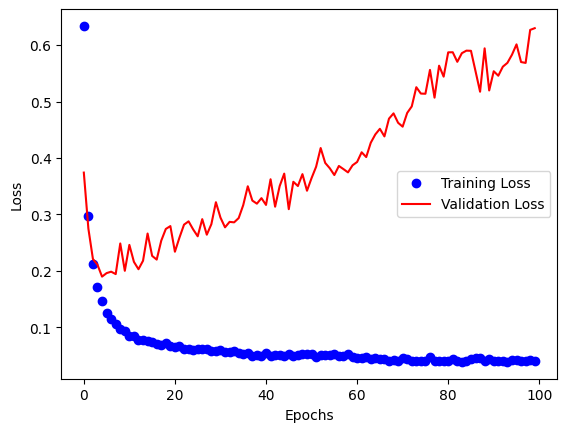

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

It was overfitting as validation loss was performing badly while training loss was decreasing well. So

In [23]:
from keras import backend as K, regularizers
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras import models

K.clear_session()


input_img = Input(shape=(784,), name='input_img')


encode1 = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='encode1')(input_img)
bn1 = BatchNormalization(name='bn1')(encode1)
drop1 = Dropout(0.2, name='drop1')(bn1)

encode2 = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='encode2')(drop1)
bn2 = BatchNormalization(name='bn2')(encode2)
drop2 = Dropout(0.2, name='drop2')(bn2)

encode3 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='encode3')(drop2)
bn3 = BatchNormalization(name='bn3')(encode3)
drop3 = Dropout(0.2, name='drop3')(bn3)

#  Bottleneck
bottleneck = Dense(2, activation='linear', name='bottleneck')(drop3)




#  Decoder branch
decode1 = Dense(64, activation='relu', name='decode1')(bottleneck)
bn4 = BatchNormalization(name='bn4')(decode1)
drop4 = Dropout(0.2, name='drop4')(bn4)

decode2 = Dense(128, activation='relu', name='decode2')(drop4)
bn5 = BatchNormalization(name='bn5')(decode2)
drop5 = Dropout(0.2, name='drop5')(bn5)

decode3 = Dense(256, activation='relu', name='decode3')(drop5)
bn6 = BatchNormalization(name='bn6')(decode3)
drop6 = Dropout(0.2, name='drop6')(bn6)

decode4 = Dense(784, activation='sigmoid', name='decode4')(drop6)

#  Classifier branch
classifier1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4), name='classifier1')(bottleneck)
bn7 = BatchNormalization(name='bn7')(classifier1)
drop7 = Dropout(0.2, name='drop7')(bn7)

classifier2 = Dense(32, activation='relu', name='classifier2')(drop7)
bn8 = BatchNormalization(name='bn8')(classifier2)
drop8 = Dropout(0.2, name='drop8')(bn8)

classifier3 = Dense(10, activation='softmax', name='classifier3')(drop8)

#  Model
sae_model = models.Model(input_img, [decode4, classifier3])
sae_model.summary()





Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode1 (Dense)     │ (None, 256)       │    200,960 │ input_img[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 256)       │      1,024 │ encode1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop1 (Dropout)     │ (None, 256)       │          0 │ bn1[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode2 (Dense)     │ (None, 128)       │     32,896 │ drop1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 128)       │        512 │ encode2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop2 (Dropout)     │ (None, 128)       │          0 │ bn2[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encode3 (Dense)     │ (None, 64)        │      8,256 │ drop2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 64)        │        256 │ encode3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop3 (Dropout)     │ (None, 64)        │          0 │ bn3[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 2)         │        130 │ drop3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode1 (Dense)     │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn4                 │ (None, 64)        │        256 │ decode1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop4 (Dropout)     │ (None, 64)        │          0 │ bn4[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode2 (Dense)     │ (None, 128)       │      8,320 │ drop4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier1 (Dense) │ (None, 64)        │        192 │ bottleneck[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn5                 │ (None, 128)       │        512 │ decode2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn7                 │ (None, 64)        │        256 │ classifier1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop5 (Dropout)     │ (None, 128)       │          0 │ bn5[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop7 (Dropout)     │ (None, 64)        │          0 │ bn7[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decode3 (Dense)     │ (None, 256)       │     33,024 │ drop5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 491,836 (1.88 MB)

 Trainable params: 489,852 (1.87 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [24]:
from keras.optimizers import RMSprop


sae_model.compile(
    optimizer=RMSprop(learning_rate=1e-3),
    loss=['mean_squared_error', 'categorical_crossentropy'],
    loss_weights=[1.0, 2.0],
    metrics=[None, 'accuracy']
)


history = sae_model.fit(
    x=x_tr,
    y=[x_tr, y_tr],
    batch_size=32,
    epochs=100,
    validation_data=(x_val, [x_val, y_val]),
    verbose=1
)


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - classifier3_accuracy: 0.3207 - classifier3_loss: 1.9421 - decode4_loss: 0.2210 - loss: 4.1697 - val_classifier3_accuracy: 0.7515 - val_classifier3_loss: 0.7574 - val_decode4_loss: 0.0770 - val_loss: 1.6560
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classifier3_accuracy: 0.6728 - classifier3_loss: 0.9487 - decode4_loss: 0.0714 - loss: 2.0317 - val_classifier3_accuracy: 0.8722 - val_classifier3_loss: 0.5019 - val_decode4_loss: 0.0574 - val_loss: 1.1237
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - classifier3_accuracy: 0.7717 - classifier3_loss: 0.7398 - decode4_loss: 0.0596 - loss: 1.6009 - val_classifier3_accuracy: 0.8918 - val_classifier3_loss: 0.4275 - val_decode4_loss: 0.0560 - val_loss: 0.9727
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - classifier3_accuracy: 0.8183 - classifier3_loss: 0.6468 - decode4_loss: 0.0588 - loss: 1.4134 - val_classifier3_accuracy: 0.9080 - val_classifier3_loss: 0.3609 

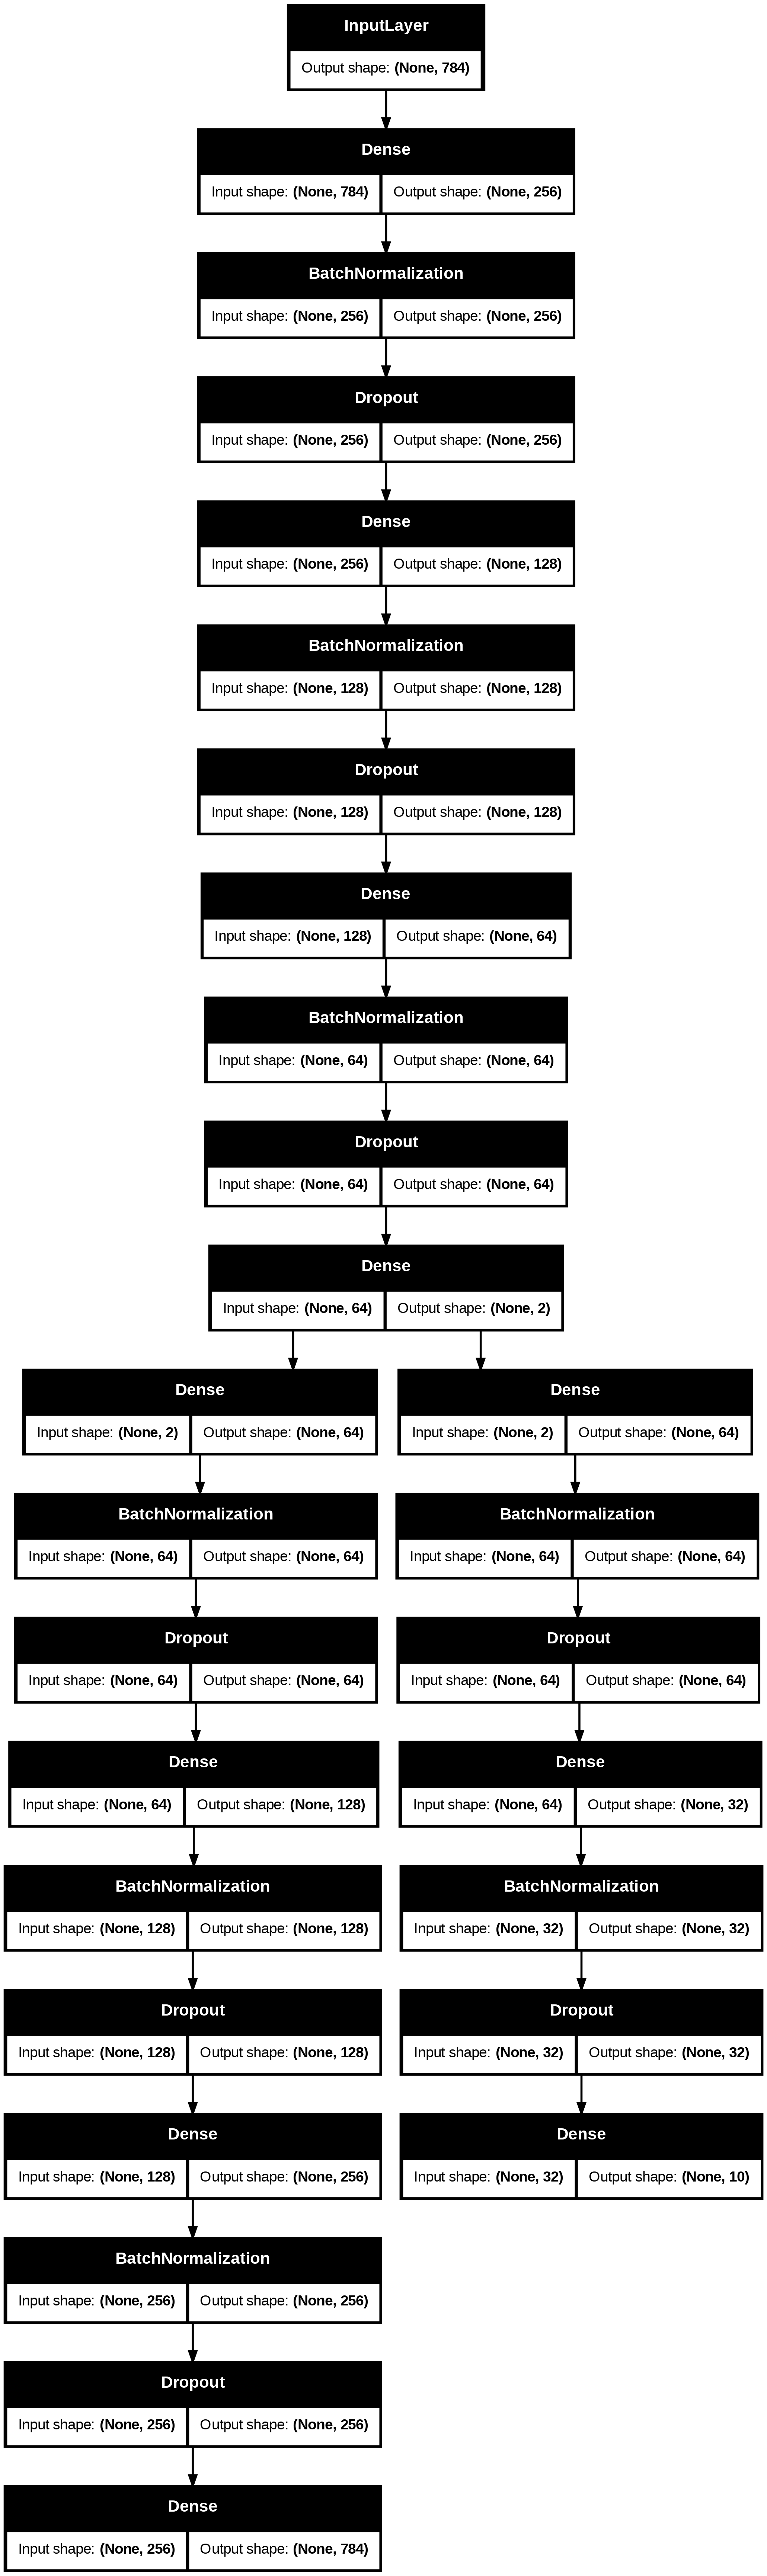

In [25]:
from keras.utils import plot_model

plot_model(
    model=sae_model,
    to_file='supervised_autoencoder.png',
    show_shapes=True
)



### 4.3. Visualize the reconstructed test images

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


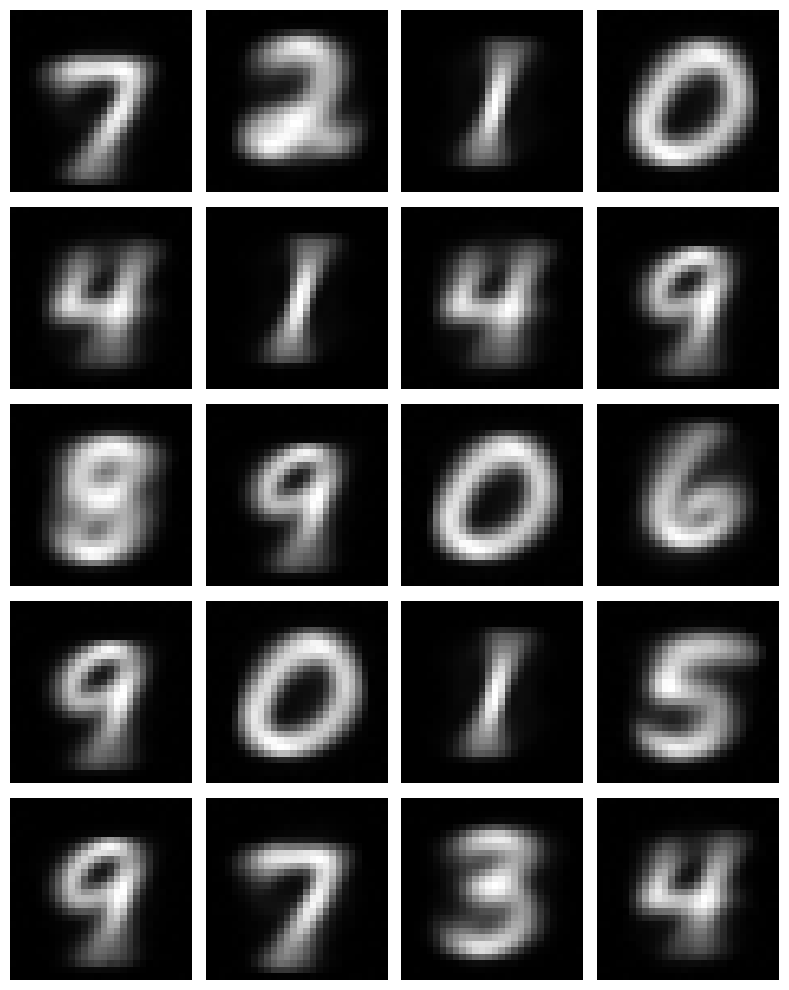

In [26]:

recons, class_preds = sae_model.predict(x_test)

sae_model = recons.reshape((recons.shape[0], 28, 28))


ROW, COLUMN = 5, 4
fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, range(ROW * COLUMN)):
    ax.imshow(sae_model[i], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig('reconstruct_sae.pdf')
plt.show()


### 4.4. Visualize the low-dimensional features



In [28]:
from keras.models import Model

# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_img (InputLayer)          │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode1 (Dense)                 │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop1 (Dropout)                 │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop2 (Dropout)                 │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encode3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop3 (Dropout)                 │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 244,034 (953.26 KB)

 Trainable params: 243,138 (949.76 KB)

 Non-trainable params: 896 (3.50 KB)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Shape of encoded_test: (10000, 2)
Shape of encoded_test: (10000, 2)


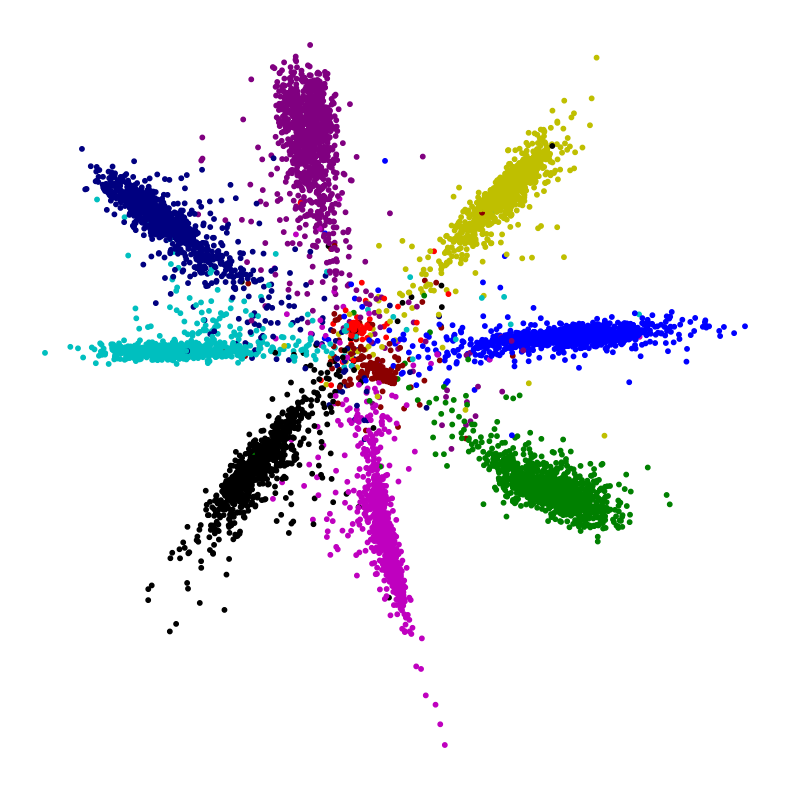

In [29]:
# extract test features
encoded_test = sae_encoder.predict(x_test, batch_size=32)
print("Shape of encoded_test:", encoded_test.shape)

print('Shape of encoded_test:', encoded_test.shape)


colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [30]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [31]:
from keras.layers import Input, Dense
from keras import models

#  Define the classifier input (2-D features)
input_feat_1= Input(shape=(2,), name='input_feat')

#  Build the classifier layers
hidden1 = Dense(128, activation='relu', name='hidden1')(input_feat_1)
hidden2 = Dense(128, activation='relu', name='hidden2')(hidden1)
opt  = Dense(10,  activation='softmax', name='output')(hidden2)


classifier = models.Model(inputs=input_feat_1, outputs=opt, name='feature_classifier')


classifier.summary()


Model: "feature_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_feat (InputLayer)         │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 128)            │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,186 (71.04 KB)

 Trainable params: 18,186 (71.04 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr,
                        batch_size=32,
                        epochs=30,
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - acc: 0.5779 - loss: 1.4037 - val_acc: 0.7941 - val_loss: 0.4975
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9366 - loss: 0.3268 - val_acc: 0.9517 - val_loss: 0.3508
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9922 - loss: 0.1769 - val_acc: 0.9514 - val_loss: 0.2979
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9890 - loss: 0.1137 - val_acc: 0.9508 - val_loss: 0.2774
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9903 - loss: 0.0701 - val_acc: 0.9517 - val_loss: 0.2720
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9905 - loss: 0.0626 - val_acc: 0.9518 - val_loss: 0.2719
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9908 - loss: 0.0571 - val_acc: 0.9529 - val_loss: 0.2735
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.9925 - loss: 0.0411 - val_acc: 0.9527 - val_loss: 0.2730
Epoch 9/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - ac

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [33]:

validation_accuracy_history = history.history['val_acc']  #


print("Validation accuracy across epochs:", validation_accuracy_history)


final_val_acc = validation_accuracy_history[-1]
print(f"Final validation accuracy: {final_val_acc * 100:.2f}%")


Validation accuracy across epochs: [0.7940999865531921, 0.95169997215271, 0.9513999819755554, 0.9508000016212463, 0.95169997215271, 0.9517999887466431, 0.9528999924659729, 0.9527000188827515, 0.9527999758720398, 0.9526000022888184, 0.9535999894142151, 0.954200029373169, 0.9535999894142151, 0.9539999961853027, 0.9546999931335449, 0.9542999863624573, 0.9545999765396118, 0.9545000195503235, 0.9544000029563904, 0.9538999795913696, 0.954200029373169, 0.9539999961853027, 0.9544000029563904, 0.9545999765396118, 0.9545999765396118, 0.9545000195503235, 0.9549999833106995, 0.9546999931335449, 0.9545000195503235, 0.9549999833106995]
Final validation accuracy: 95.50%


In [34]:
#  Evaluate on the never-seen-before test set
test_classification_loss, test_classification_accuracy = classifier.evaluate(
    f_te,
    y_test_vec,
    batch_size=32,
    verbose=1
)

print(f"Test classification loss:     {test_classification_loss:.4f}")
print(f"Test classification accuracy: {test_classification_accuracy * 100:.2f}%")

# Ensure accuracy threshold is met
assert test_classification_accuracy >= 0.90, "Test accuracy did not reach 90%!"



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.9510 - loss: 0.2850
Test classification loss:     0.2350
Test classification accuracy: 95.90%
